# Урок 5. Алгоритм DBSCAN

Алгоритм k-средних хорошо справляется с задачей кластеризации в случае, когда кластеры линейно разделимы и представляют собой отдельные скопления точек.

Однако, часто никаких отдельных множеств нет и кластеры плавно переходят друг в друга, но при этом хорошо видны области, где плотность точек (количество на единицу площади) больше, чем в других областях. на картинке ниже кластеры как бы "проникают" друг в друга. Поэтому алгорим DBSCAN, о котором мы и поговорим в этом уроке, справляется хорошо, а вот у K-means серьёзные проблемы - он находить три кластера вместо двух:

![kmeans_vs_dbcan](https://248006.selcdn.ru/public/DS.%20Block%202.%20M7/kmeans_vs_dbcan.png)

. DBSCAN (Density-based spatial clustering of applications with noise, плотностной алгоритм пространственной кластеризации с присутствием шума) принимает на вход два параметра

* $\varepsilon$ - радиус окрестности, в котором мы ищем соседей каждой точки
* пороговое значение $k$ количества соседей внутри радиуса $\varepsilon$

Оба этих параметра подбираются на валидационной выборке с помощью процедуры GridSearch, с которой вы познакомились в уроке про линейную регрессию.

Как  будет работать этот алгоритм? В первом приближении можно сказать, что мы будем ориентироваться на плотность точек: если в какой-то точке пространства точки лежат очень "густо" - там скорее всего, кластер. Если густота точек снижается, то мы, видимо, попали на границу кластера. А вот если у точки совсем нет соседей - наверное, это какой-то выброс и такая точка вообще ни в один кластер не входит.

Алгоритм построения кластеров
следующий

1. Для каждой точки считаем, сколько у нее есть соседей в том радиусе, который указывали в параметрах (назовем число соседей $m$)
1. Каждая точка, у которой соседей достаточно много (т.е. $m \ge k$, которое мы тоже указывали в параметрах), будет считаться "внутри кластера" и называться опорной
1. Остальные точки поделим на две группы. 
    1. Если соседей в том же радиусе у них мало, но среди этих соседей есть точка, которая "внутри кластера" (мы все такие нашли на предыдущем шаге) - это точка будет считаться лежащей на границе кластера
    1. Все остальные будут считаться выбросами
1. Теперь объединим точки в кластеры. Возьмем любую из опорных точек и объединим ее со всеми ее соседями, которые при этом тоже являются опорными. Так получается первый кластер. Будем повторять это для оставшихся опорных точек, формируя кластер за кластером, пока не опорные точки не закончатся

Алгоритм визуализирован на картинке

![dbscan.img](https://248006.selcdn.ru/public/DS.%20Block%202.%20M7/dbscan.png)

Такая схема алгоритма проста для понимания, но сложна в реализации. На практике кластеры  будут формироваться итеративно:

1. Берём случайную точку из датасета. Если меньше $k$ соседей в окрестности, то помечаем её как возможный `outlier` 
1. Добавляем её в список опорных элементов, если это возможно, исключаем из списка точек, которые надо обойти
    1. Создаём новый кластер, в который добавляем эту точку - например, в виде массива с порядковыми номерами элементов из исходного датасета
    1. Обходим всех соседей этой "опорной" точки. Если сосед уже в списке потенциальных `outliers` или у него меньше $k$ соседей в окрестности, то ничего не делаем. Иначе новая точка присоединяется к тому же кластеру, что и текущая.
1. Повторяем шаги, пока в датасете не исчерпаются данные

После окончания работы алгоритма у нас все точки окажутся разделёнными на две части: опорные и выбросы.

Конечно же мы такой сложный алгоритм реализовывать не будем, просто воспользуемся готовой реализацией из библиотеки sklearn. Для начала загрузим исходные данные

In [0]:
import pickle
import numpy as np

# данные получены с помощью функции make_classification 
with open('data/clustering.pkl', 'rb') as f:
    data_clustering = pickle.load(f)

X = np.array(data_clustering['X'])
Y = np.array(data_clustering['Y'])

Обучение модели

In [0]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.6, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

Визуализация результатов

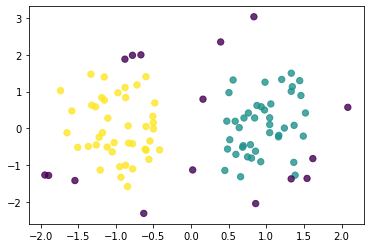

In [0]:
labels = db.labels_

plt.scatter(X[:, 0], X[:, 1], s=40, c=labels, marker='o', alpha=0.8, label='data')
plt.show()